In [1]:
import gym
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from gym import spaces

In [2]:
class Warehouse_robot(gym.Env):
    def __init__(self):
        super(Warehouse_robot, self).__init__()

        self.grid_size = 6
        self.start_position = (0, 0)
        self.item_position = (2, 2)
        self.dropoff_position = (5, 5)
        self.robot_pos = self.start_position
        self.carrying = False
        self.obstacles = [(1, 3), (2, 4), (3, 2), (4, 3)]
        self.action_space = spaces.Discrete(6)
        self.observation_space = spaces.MultiDiscrete([self.grid_size, self.grid_size, 2])
        self.idle_agent_image = mpimg.imread("idle_agent.jpg")
        self.agent_carrying_package_image = mpimg.imread("agent_carrying_package.jpg")
        self.obstacle_img = mpimg.imread("obstacle.jpg")
        self.item_package_image = mpimg.imread("package.jpg")
        self.white_background_image = mpimg.imread("white_background.png")

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.robot_pos = self.start_position
        self.carrying = False
        observation = np.array([self.robot_pos[0], self.robot_pos[1], int(self.carrying)])
        info = {}  # Additional debug info if needed
        return observation, info

    def step(self, action):
        a, b = self.robot_pos
        terminated = False  # Gymnasium uses "terminated"
        truncated = False   # Gymnasium adds "truncated" for time limits
        
        if action == 0 and b > 0:
            b -= 1
        elif action == 1 and b < self.grid_size - 1:
            b += 1
        elif action == 2 and a > 0:
            a -= 1
        elif action == 3 and a < self.grid_size - 1:
            a += 1

        if (a, b) in self.obstacles:
            a, b = self.robot_pos
            reward = -20
        else:
            reward = -1

        if action == 4 and (a, b) == self.item_position and not self.carrying:
            self.carrying = True
            reward = 25
        elif action == 5 and (a, b) == self.dropoff_position and self.carrying:
            reward = 100
            terminated = True  # Mark as complete when the item is delivered
        
        self.robot_pos = (a, b)
        
        observation = np.array([a, b, int(self.carrying)])
        info = {}  # Any additional info
        
        return observation, reward, terminated, truncated, info

    def render(self):
        figure, axis = plt.subplots(figsize=(5, 5))
        axis.imshow(self.white_background_image)

        for (ox, oy) in self.obstacles:
            axis.imshow(self.obstacle_img, extent=[ox, ox + 1, oy, oy + 1])
            
        if not self.carrying:
            ix, iy = self.item_position
            axis.imshow(self.item_package_image, extent=[ix, ix + 1, iy, iy + 1])
        rx, ry = self.robot_pos
        if self.carrying:
            axis.imshow(self.agent_carrying_package_image, extent=[rx, rx + 1, ry, ry + 1])
        else:
            axis.imshow(self.idle_agent_image, extent=[rx, rx + 1, ry, ry + 1])
        plt.xlim(0, self.grid_size)
        plt.ylim(0, self.grid_size)
        plt.grid()
        plt.show()


Step: 1
  Action Taken: Left
  Current State: Position=[0 0], Carrying Item=False
  Reward: -1
  Done: False



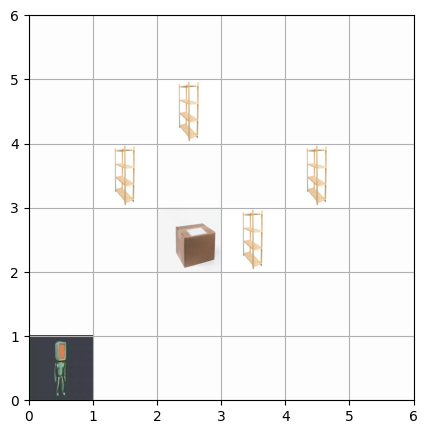

Step: 2
  Action Taken: Right
  Current State: Position=[1 0], Carrying Item=False
  Reward: -1
  Done: False



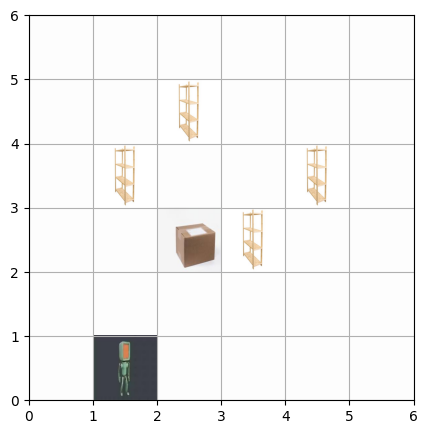

Step: 3
  Action Taken: Left
  Current State: Position=[0 0], Carrying Item=False
  Reward: -1
  Done: False



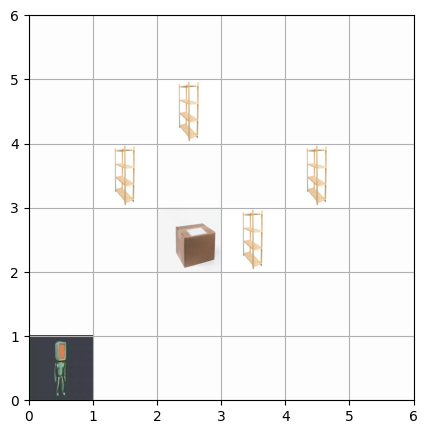

Step: 4
  Action Taken: Right
  Current State: Position=[1 0], Carrying Item=False
  Reward: -1
  Done: False



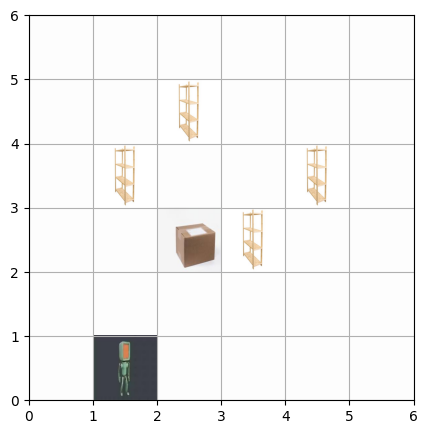

Step: 5
  Action Taken: Pick-up
  Current State: Position=[1 0], Carrying Item=False
  Reward: -1
  Done: False



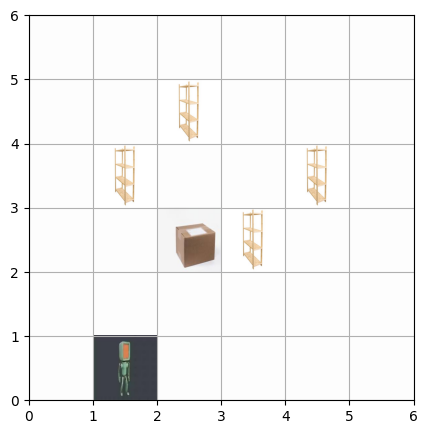

Step: 6
  Action Taken: Right
  Current State: Position=[2 0], Carrying Item=False
  Reward: -1
  Done: False



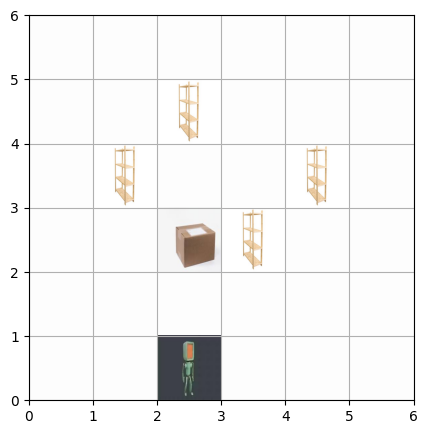

Step: 7
  Action Taken: Drop-off
  Current State: Position=[2 0], Carrying Item=False
  Reward: -1
  Done: False



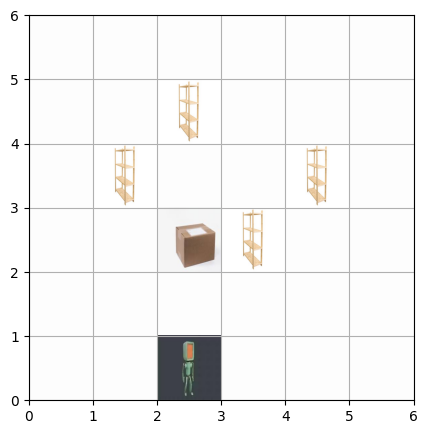

Step: 8
  Action Taken: Up
  Current State: Position=[2 1], Carrying Item=False
  Reward: -1
  Done: False



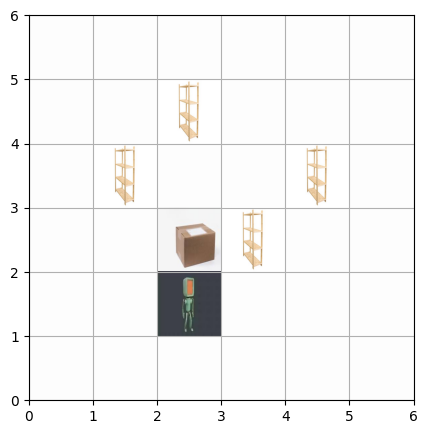

Step: 9
  Action Taken: Right
  Current State: Position=[3 1], Carrying Item=False
  Reward: -1
  Done: False



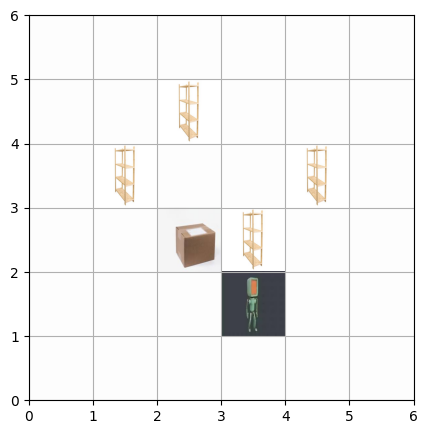

Step: 10
  Action Taken: Pick-up
  Current State: Position=[3 1], Carrying Item=False
  Reward: -1
  Done: False



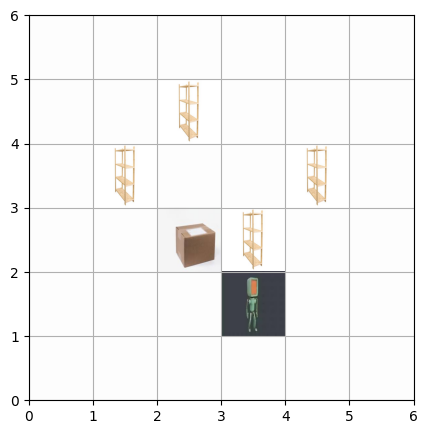

In [3]:
environment = Warehouse_robot()
initial_state = environment.reset()
mapped_actions = {1: "Up", 0: "Down", 2: "Left", 3: "Right", 4: "Pick-up", 5: "Drop-off"}

for step in range(10):
    action = environment.action_space.sample()
    next_state, r, finished, truncated, _ = environment.step(action)  # step() now returns 5 values
    print(f"Step: {step + 1}")
    print(f"  Action Taken: {mapped_actions[action]}")
    print(f"  Current State: Position={next_state[:2]}, Carrying Item={bool(next_state[2])}")
    print(f"  Reward: {r}")
    print(f"  Done: {finished or truncated}\n")  # Consider termination due to truncation
    environment.render()
    
    if finished or truncated:  # Ensure we stop if episode ends
        print("Task completed! The robot successfully delivered the item.")
        break

In [4]:
class Stochastic_warehouse(gym.Env):
    def __init__(self):
        super(Stochastic_warehouse, self).__init__()
        self.grid_size = 6
        self.start_position = (0, 0)
        self.item_position = (2, 2)
        self.dropoff_position = (5, 5)
        self.robot_start_position = self.start_position
        self.carrying = False
        self.obstacles = [(1, 3), (2, 4), (3, 2), (4, 3)]
        self.dynamic_obstacles = [(0, 5), (3, 4)]  
        self.action_space = spaces.Discrete(6)
        self.observation_space = spaces.MultiDiscrete([self.grid_size, self.grid_size, 2])
        self.agent_idle_img = mpimg.imread("idle_agent.jpg")
        self.agent_carrying_img = mpimg.imread("agent_carrying_package.jpg")
        self.obstacle_img = mpimg.imread("obstacle.jpg")
        self.item_img = mpimg.imread("package.jpg")
        self.white_background_image = mpimg.imread("white_background.png")

    def reset(self):
        self.robot_start_position = self.start_position
        self.carrying = False
        observation = np.array([self.robot_start_position[0], self.robot_start_position[1], int(self.carrying)])
        info = {}
        return observation, info

    def step(self, action):
        a, b = self.robot_start_position
        stochastic_nature = 0.1
        terminated = False
        truncated = False
        
        if action in [0, 1, 2, 3]:
            if random.uniform(0, 1) > stochastic_nature:
                if action == 0 and b > 0:
                    b -= 1
                elif action == 1 and b < self.grid_size - 1:
                    b += 1
                elif action == 2 and a > 0:
                    a -= 1
                elif action == 3 and a < self.grid_size - 1:
                    a += 1

        if (a, b) in self.obstacles or (a, b) in self.dynamic_obstacles:
            a, b = self.robot_start_position
            reward = -20
        else:
            reward = -1

        if action == 4 and (a, b) == self.item_position and not self.carrying:
            self.carrying = True
            reward = 25
        elif action == 5 and (a, b) == self.dropoff_position and self.carrying:
            reward = 100
            terminated = True  

        self.robot_start_position = (a, b)
        observation = np.array([a, b, int(self.carrying)])
        info = {}
        return observation, reward, terminated, truncated, info

    def render(self):
        figure, axis = plt.subplots(figsize=(6, 6))
        axis.set_xticks(range(self.grid_size + 1))
        axis.set_yticks(range(self.grid_size + 1))
        axis.grid(True)
        axis.set_xlim(0, self.grid_size)
        axis.set_ylim(0, self.grid_size)

        for obs in self.obstacles:
            axis.imshow(self.obstacle_img, extent=[obs[0], obs[0] + 1, obs[1], obs[1] + 1])
        for obs in self.dynamic_obstacles:
            axis.imshow(self.obstacle_img, extent=[obs[0], obs[0] + 1, obs[1], obs[1] + 1])
        axis.imshow(self.item_img, extent=[self.item_position[0], self.item_position[0] + 1, self.item_position[1], self.item_position[1] + 1])
        axis.imshow(self.item_img, extent=[self.dropoff_position[0], self.dropoff_position[0] + 1, self.dropoff_position[1], self.dropoff_position[1] + 1])
        agent_image = self.agent_carrying_img if self.carrying else self.agent_idle_img
        axis.imshow(agent_image, extent=[self.robot_start_position[0], self.robot_start_position[0] + 1, self.robot_start_position[1], self.robot_start_position[1] + 1])
        plt.show()

Step: 1
  Action Taken: Right
  Current State: Position=[1 0], Carrying Item=False
  Reward: -1
  Done: False



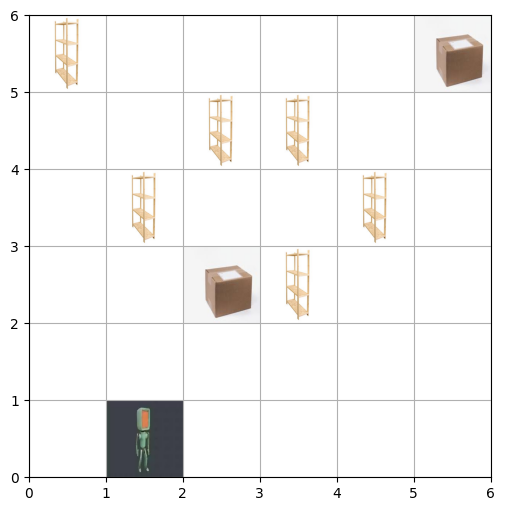

Step: 2
  Action Taken: Up
  Current State: Position=[1 0], Carrying Item=False
  Reward: -1
  Done: False



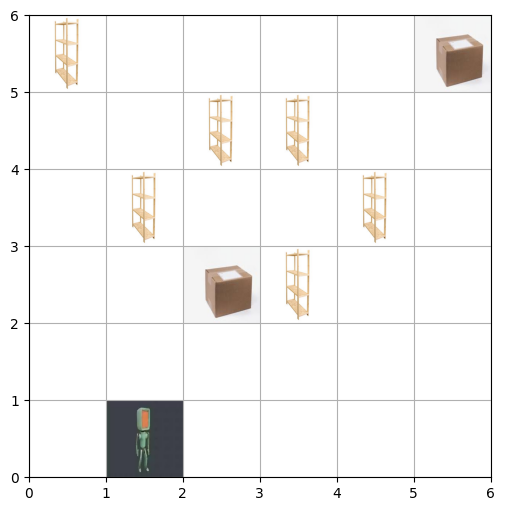

Step: 3
  Action Taken: Down
  Current State: Position=[1 0], Carrying Item=False
  Reward: -1
  Done: False



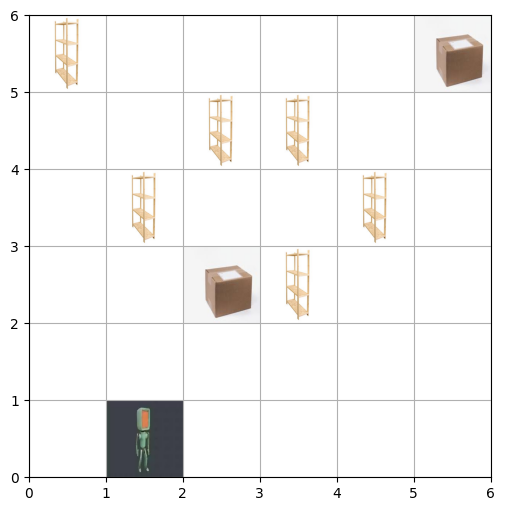

Step: 4
  Action Taken: Up
  Current State: Position=[1 1], Carrying Item=False
  Reward: -1
  Done: False



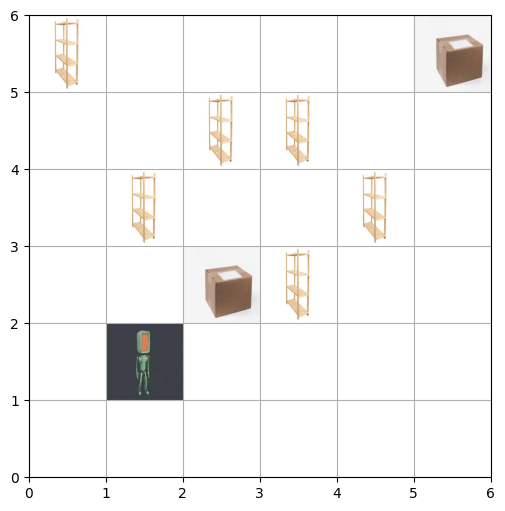

Step: 5
  Action Taken: Right
  Current State: Position=[2 1], Carrying Item=False
  Reward: -1
  Done: False



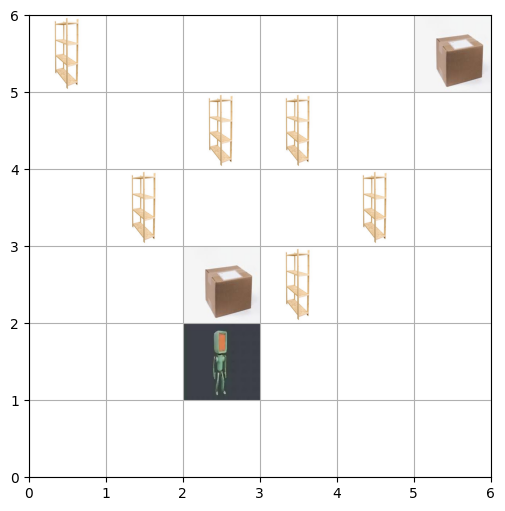

Step: 6
  Action Taken: Up
  Current State: Position=[2 2], Carrying Item=False
  Reward: -1
  Done: False



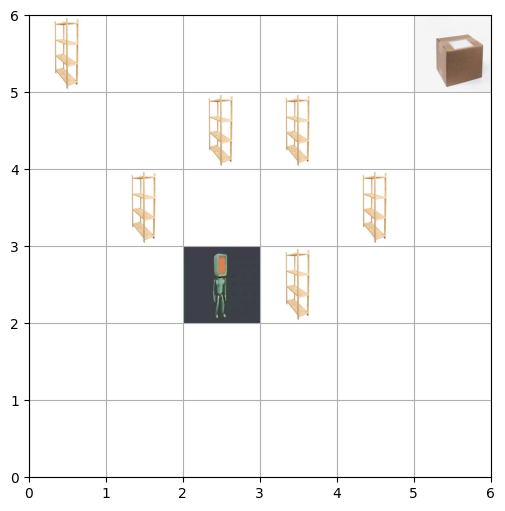

Step: 7
  Action Taken: Drop-off
  Current State: Position=[2 2], Carrying Item=False
  Reward: -1
  Done: False



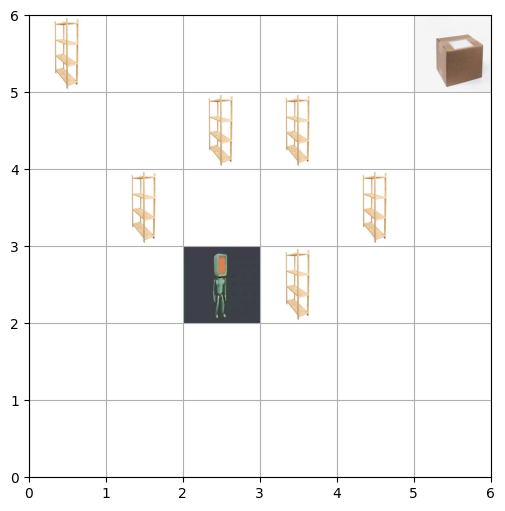

Step: 8
  Action Taken: Down
  Current State: Position=[2 1], Carrying Item=False
  Reward: -1
  Done: False



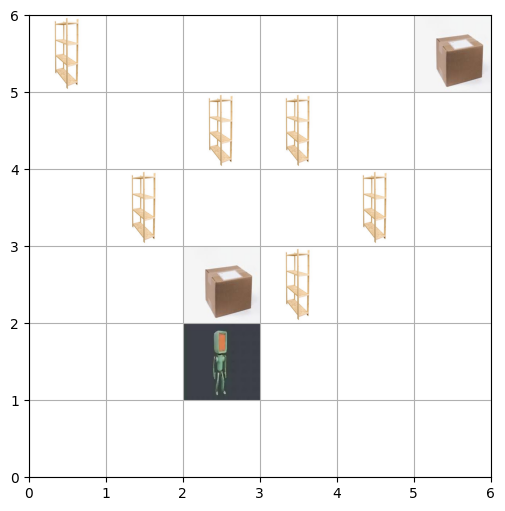

Step: 9
  Action Taken: Down
  Current State: Position=[2 0], Carrying Item=False
  Reward: -1
  Done: False



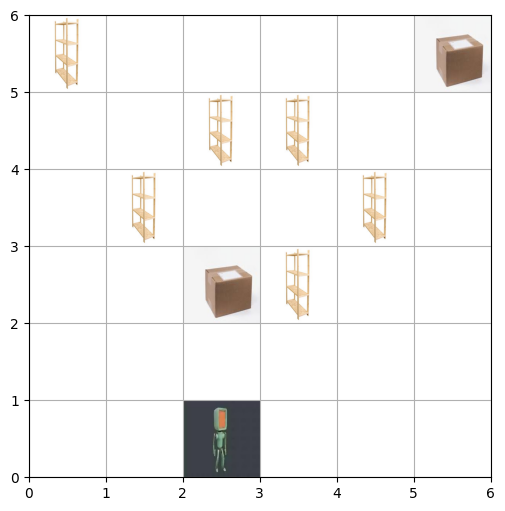

Step: 10
  Action Taken: Down
  Current State: Position=[2 0], Carrying Item=False
  Reward: -1
  Done: False



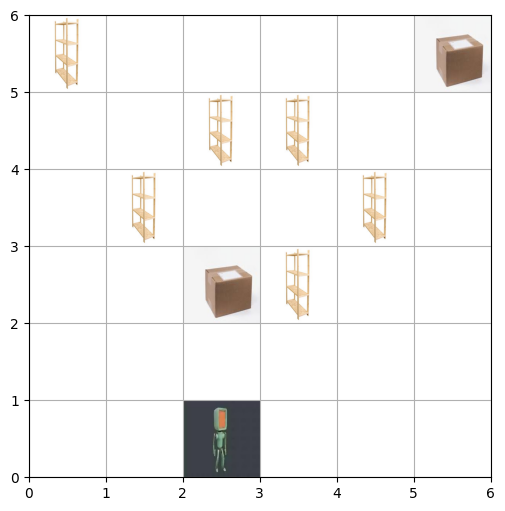

In [5]:
env = Stochastic_warehouse()
state = env.reset()
mapped_actions = {1: "Up", 0: "Down", 2: "Left", 3: "Right", 4: "Pick-up", 5: "Drop-off"}

for step in range(10):
    action = env.action_space.sample()
    next_state, r, finished, truncated, _ = env.step(action)  # step() now returns 5 values
    print(f"Step: {step + 1}")
    print(f"  Action Taken: {mapped_actions[action]}")
    print(f"  Current State: Position={next_state[:2]}, Carrying Item={bool(next_state[2])}")
    print(f"  Reward: {r}")
    print(f"  Done: {finished or truncated}\n")  # Consider termination due to truncation
    env.render()
    
    if finished or truncated:  # Ensure we stop if episode ends
        print("Task completed! The robot successfully delivered the item.")
        break

### BONUS: MULTIPLE PICK UP AND DROP

In [23]:
class Warehouse_robot(gym.Env):
    def __init__(self):
        super(Warehouse_robot, self).__init__()
        self.grid_size = 6
        self.start_position = (0, 0)
        self.dropoff_position = (5, 5)
        self.robot_position = self.start_position
        self.carrying = False
        self.obstacles = [(1, 3), (2, 4), (3, 2), (4, 3)]
        self.max_steps = 10
        self.current_step = 0
        self.item_position = self._generate_random_item_position()
        self.action_space = spaces.Discrete(6)
        self.observation_space = spaces.MultiDiscrete([self.grid_size, self.grid_size, 2])
        self.agent_idle_img = mpimg.imread("idle_agent.jpg")  
        self.agent_carrying_img = mpimg.imread("agent_carrying_package.jpg")  
        self.obstacle_img = mpimg.imread("obstacle.jpg")  
        self.item_img = mpimg.imread("package.jpg")  
        self.background_img = mpimg.imread("white_background.png")  

    def _generate_random_item_position(self):
        while True:
            pos = (random.randint(0, self.grid_size - 1), random.randint(0, self.grid_size - 1))
            if pos not in self.obstacles and pos != self.start_position and pos != self.dropoff_position:
                return pos

    def reset(self):
        self.robot_position = self.start_position
        self.carrying = False
        self.current_step = 0
        self.item_position = self._generate_random_item_position()
        return np.array([self.robot_position[0], self.robot_position[1], int(self.carrying)])

    def step(self, action):
        a, b = self.robot_position
        self.current_step += 1
        done = False
        if action == 0 and b > 0:  
            b -= 1
        elif action == 1 and b < self.grid_size - 1:  
            b += 1
        elif action == 2 and a > 0:  
            a -= 1
        elif action == 3 and a < self.grid_size - 1:  
            a += 1
        if (a, b) in self.obstacles:
            a, b = self.robot_position  
            reward = -20  
        else:
            reward = -1  
        if action == 4 and (a, b) == self.item_position and not self.carrying:
            self.carrying = True
            reward = 25  
        elif action == 5 and (a, b) == self.dropoff_position and self.carrying:
            reward = 100  
            self.carrying = False
            self.item_position = self._generate_random_item_position()
            print("Item delivered! New pick-up location assigned:", self.item_position)
        if self.current_step >= self.max_steps:
            done = True
        self.robot_position = (a, b)
        return np.array([a, b, int(self.carrying)]), reward, done, {}

    def render(self):
        fig, ax = plt.subplots(figsize=(5, 5))
        ax.imshow(self.background_img)
        for (ox, oy) in self.obstacles:
            ax.imshow(self.obstacle_img, extent=[ox, ox + 1, oy, oy + 1])
        if not self.carrying:
            ix, iy = self.item_position
            ax.imshow(self.item_img, extent=[ix, ix + 1, iy, iy + 1])
        rx, ry = self.robot_position
        if self.carrying:
            ax.imshow(self.agent_carrying_img, extent=[rx, rx + 1, ry, ry + 1])
        else:
            ax.imshow(self.agent_idle_img, extent=[rx, rx + 1, ry, ry + 1])
        plt.xlim(0, self.grid_size)
        plt.ylim(0, self.grid_size)
        plt.grid()
        plt.show()


Step: 1
  Action Taken: Down
  Current State: Position=[0 0], Carrying Item=False
  Reward: -1
  Done: False



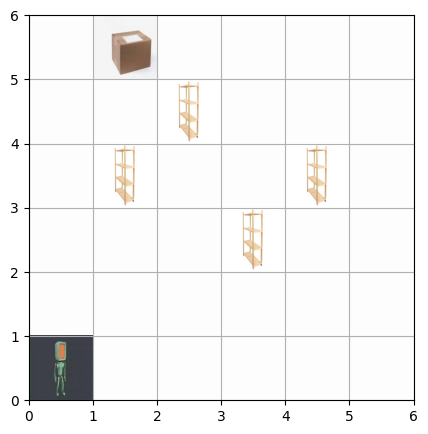

Step: 2
  Action Taken: Right
  Current State: Position=[1 0], Carrying Item=False
  Reward: -1
  Done: False



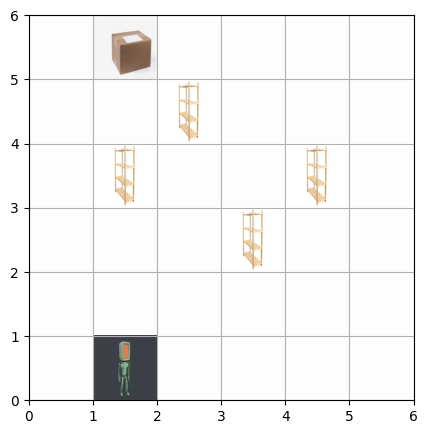

Step: 3
  Action Taken: Down
  Current State: Position=[1 0], Carrying Item=False
  Reward: -1
  Done: False



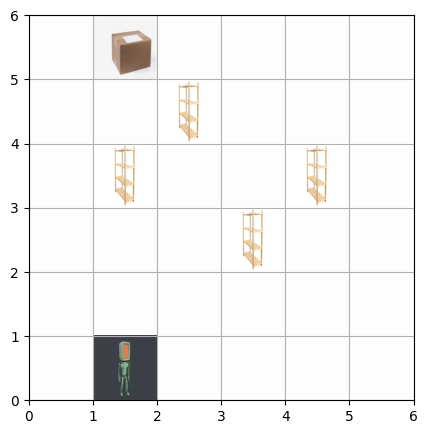

Step: 4
  Action Taken: Left
  Current State: Position=[0 0], Carrying Item=False
  Reward: -1
  Done: False



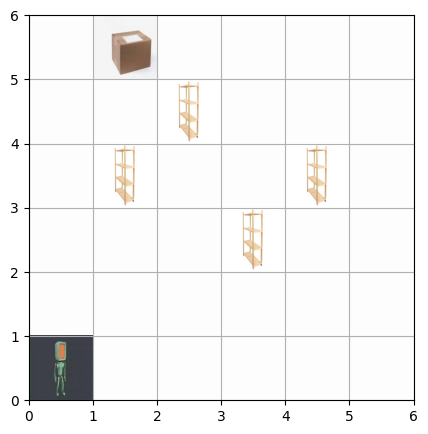

Step: 5
  Action Taken: Down
  Current State: Position=[0 0], Carrying Item=False
  Reward: -1
  Done: False



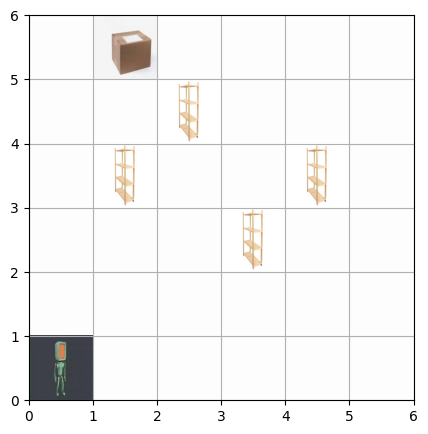

Step: 6
  Action Taken: Down
  Current State: Position=[0 0], Carrying Item=False
  Reward: -1
  Done: False



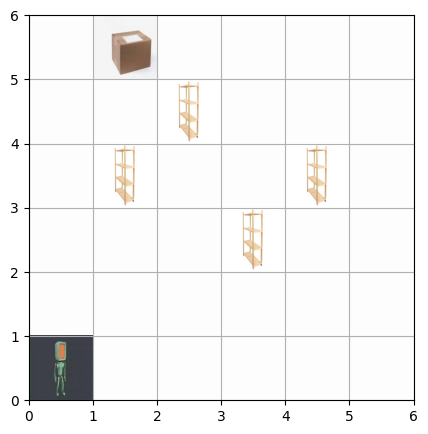

Step: 7
  Action Taken: Drop-off
  Current State: Position=[0 0], Carrying Item=False
  Reward: -1
  Done: False



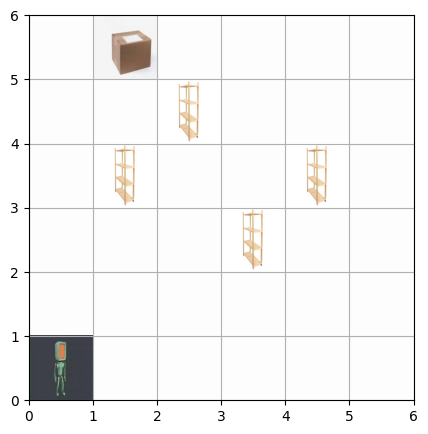

Step: 8
  Action Taken: Pick-up
  Current State: Position=[0 0], Carrying Item=False
  Reward: -1
  Done: False



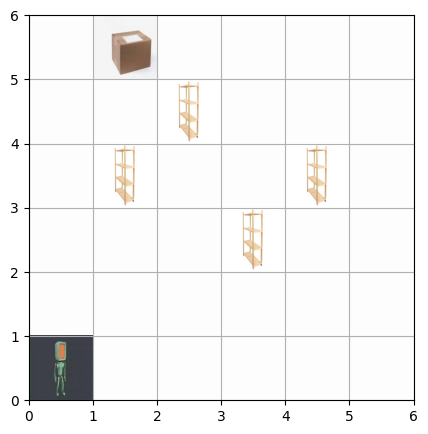

Step: 9
  Action Taken: Up
  Current State: Position=[0 1], Carrying Item=False
  Reward: -1
  Done: False



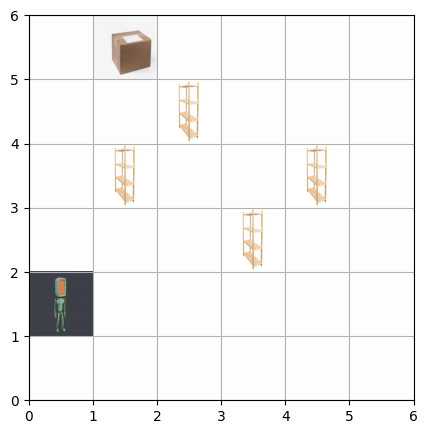

Step: 10
  Action Taken: Down
  Current State: Position=[0 0], Carrying Item=False
  Reward: -1
  Done: True



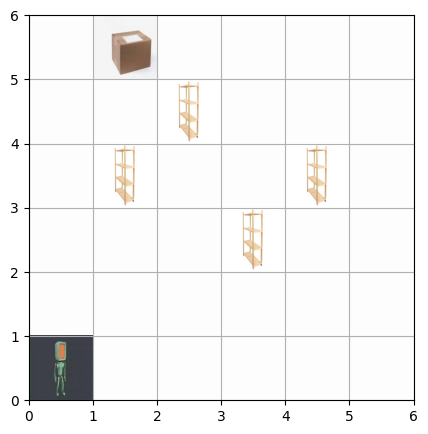

Episode ended.


In [24]:
env = Warehouse_robot()
state = env.reset()
mapped_actions = {1: "Up", 0: "Down", 2: "Left", 3: "Right", 4: "Pick-up", 5: "Drop-off"}

for step in range(env.max_steps):
    action = env.action_space.sample()
    next_state, reward, done, _ = env.step(action)
    print(f"Step: {step + 1}")
    print(f"  Action Taken: {mapped_actions[action]}")
    print(f"  Current State: Position={next_state[:2]}, Carrying Item={bool(next_state[2])}")
    print(f"  Reward: {reward}")
    print(f"  Done: {done}\n")
    env.render()
    if done:
        print("Episode ended.")
        break

In [25]:
class Stochastic_warehouse(gym.Env):
    def __init__(self):
        super(Stochastic_warehouse, self).__init__()
        self.grid_size = 6
        self.start_position = (0, 0)
        self.dropoff_position = (5, 5)
        self.robot_position = self.start_position
        self.carrying_item = False
        self.obstacles = [(1, 3), (2, 4), (3, 2), (4, 3)]
        self.dynamic_obstacles = [(0, 5), (3, 4)]  
        self.max_deliveries = 3
        self.deliveries_completed = 0
        self.item_position = self.random_item_position()
        self.action_space = spaces.Discrete(6)  
        self.observation_space = spaces.MultiDiscrete([self.grid_size, self.grid_size, 2])
        self.agent_idle_img = mpimg.imread("idle_agent.jpg")  
        self.agent_carrying_img = mpimg.imread("agent_carrying_package.jpg")  
        self.obstacle_img = mpimg.imread("obstacle.jpg")  
        self.item_img = mpimg.imread("package.jpg")  
        self.background_img = mpimg.imread("white_background.png")  

    def random_item_position(self):
        while True:
            pos = (random.randint(0, self.grid_size - 1), random.randint(0, self.grid_size - 1))
            if pos not in self.obstacles and pos not in self.dynamic_obstacles and pos != self.dropoff_position and pos != self.start_position:
                return pos

    def reset(self):
        self.robot_position = self.start_position
        self.carrying_item = False
        self.deliveries_completed = 0
        self.item_position = self.random_item_position()
        return np.array([self.robot_position[0], self.robot_position[1], int(self.carrying_item)])

    def step(self, action):
        x, y = self.robot_position
        stochasticity = 0.1  
        if action in [0, 1, 2, 3]:
            if random.uniform(0, 1) > stochasticity:  
                if action == 0 and y > 0: y -= 1  
                elif action == 1 and y < self.grid_size - 1: y += 1  
                elif action == 2 and x > 0: x -= 1  
                elif action == 3 and x < self.grid_size - 1: x += 1  
        if (x, y) in self.obstacles or (x, y) in self.dynamic_obstacles:
            x, y = self.robot_position  
            reward = -20
        else:
            reward = -1
        if action == 4 and (x, y) == self.item_position and not self.carrying_item:
            self.carrying_item = True
            reward = 25
        elif action == 5 and (x, y) == self.dropoff_position and self.carrying_item:
            self.carrying_item = False
            self.deliveries_completed += 1
            reward = 100
            if self.deliveries_completed < self.max_deliveries:
                self.item_position = self.random_item_position()
            else:
                done = True
                return np.array([x, y, int(self.carrying_item)]), reward, done, {}
        done = False
        self.robot_position = (x, y)
        return np.array([x, y, int(self.carrying_item)]), reward, done, {}

    def render(self):
        fig, ax = plt.subplots(figsize=(6, 6))
        ax.set_xticks(range(self.grid_size + 1))
        ax.set_yticks(range(self.grid_size + 1))
        ax.grid(True)
        ax.set_xlim(0, self.grid_size)
        ax.set_ylim(0, self.grid_size)
        for obs in self.obstacles:
            ax.imshow(self.obstacle_img, extent=[obs[0], obs[0] + 1, obs[1], obs[1] + 1])
        for obs in self.dynamic_obstacles:
            ax.imshow(self.obstacle_img, extent=[obs[0], obs[0] + 1, obs[1], obs[1] + 1])
        if not self.carrying_item:
            ax.imshow(self.item_img, extent=[self.item_position[0], self.item_position[0] + 1, self.item_position[1], self.item_position[1] + 1])
        ax.imshow(self.item_img, extent=[self.dropoff_position[0], self.dropoff_position[0] + 1, self.dropoff_position[1], self.dropoff_position[1] + 1])
        agent_img = self.agent_carrying_img if self.carrying_item else self.agent_idle_img
        ax.imshow(agent_img, extent=[self.robot_position[0], self.robot_position[0] + 1, self.robot_position[1], self.robot_position[1] + 1])
        plt.show()


Step 1: Action = Drop-off, State = [0 0 0], Reward = -1, Done = False


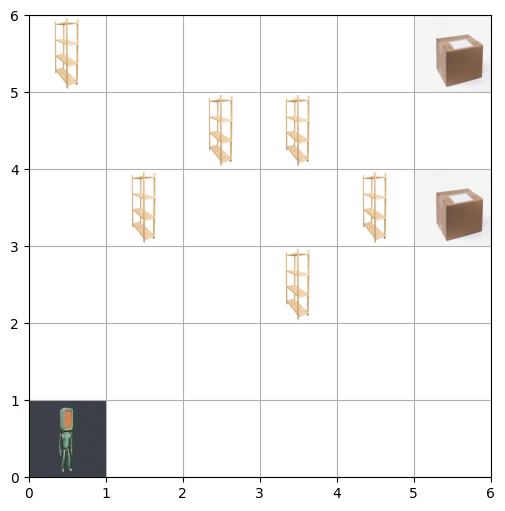

Step 2: Action = Left, State = [0 0 0], Reward = -1, Done = False


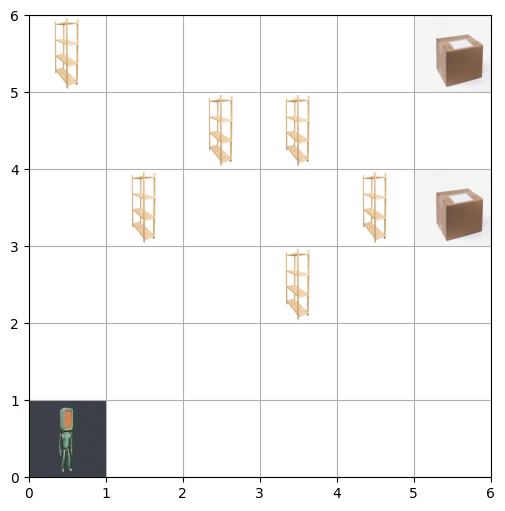

Step 3: Action = Right, State = [1 0 0], Reward = -1, Done = False


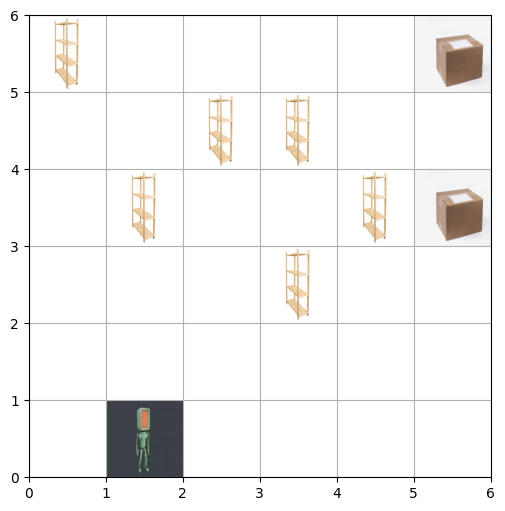

Step 4: Action = Drop-off, State = [1 0 0], Reward = -1, Done = False


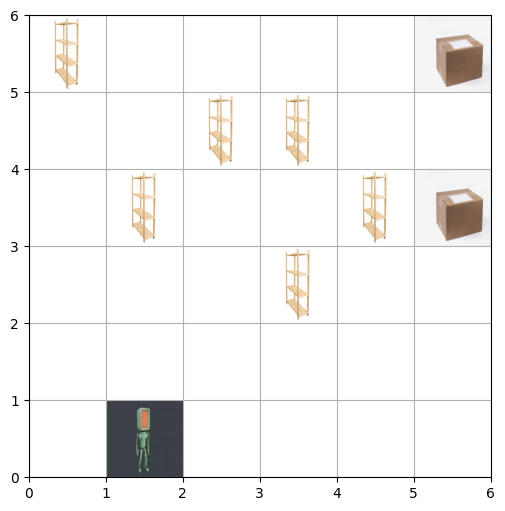

Step 5: Action = Right, State = [2 0 0], Reward = -1, Done = False


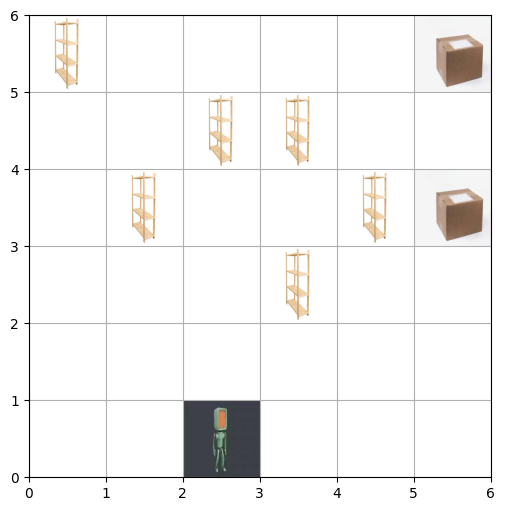

Step 6: Action = Pick-up, State = [2 0 0], Reward = -1, Done = False


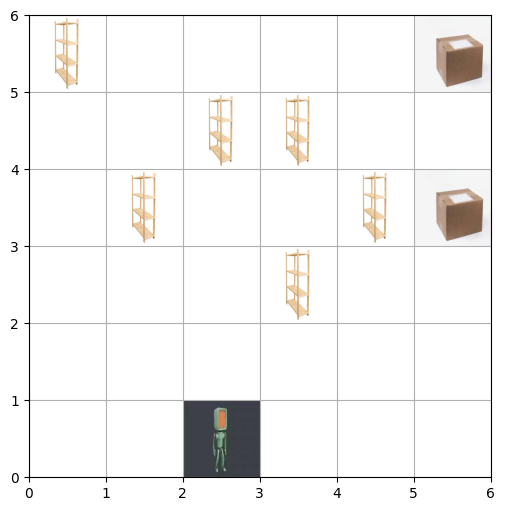

Step 7: Action = Drop-off, State = [2 0 0], Reward = -1, Done = False


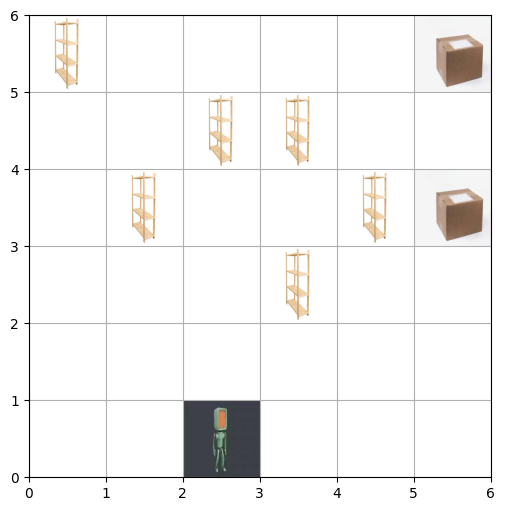

Step 8: Action = Left, State = [1 0 0], Reward = -1, Done = False


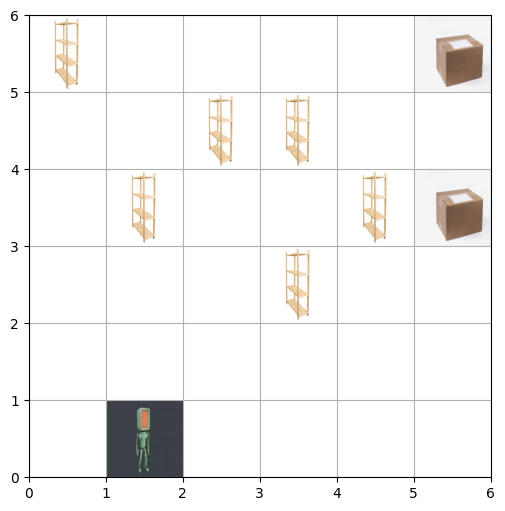

Step 9: Action = Left, State = [1 0 0], Reward = -1, Done = False


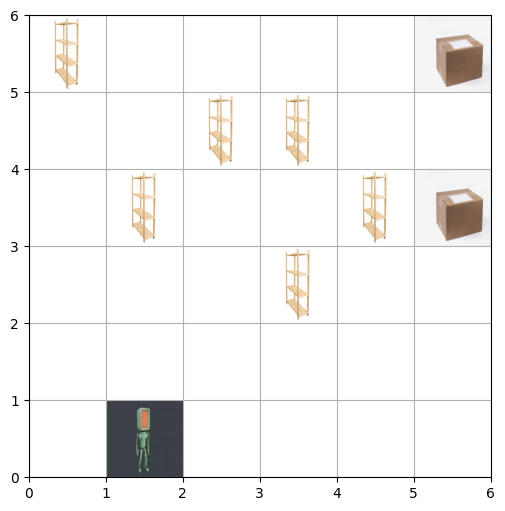

Step 10: Action = Down, State = [1 0 0], Reward = -1, Done = False


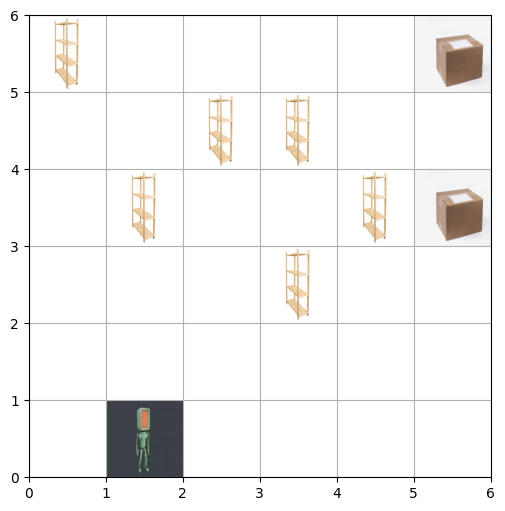

In [26]:
env = Stochastic_warehouse()
state = env.reset()
action_mapping = {1: "Up", 0: "Down", 2: "Left", 3: "Right", 4: "Pick-up", 5: "Drop-off"}

for step in range(10):
    action = env.action_space.sample()
    next_state, reward, done, _ = env.step(action)
    print(f"Step {step + 1}: Action = {action_mapping[action]}, State = {next_state}, Reward = {reward}, Done = {done}")
    env.render()
    if done:
        print("Task completed! The robot successfully delivered all items.")
        break

### References:

1) https://www.geeksforgeeks.org/deterministic-vs-stochastic-environment-in-ai/
2) https://www.geeksforgeeks.org/types-of-environments-in-ai/
3) https://medium.com/@mohannadrateb84/reinforcement-learning-deterministic-policy-vs-stochastic-policy-eabae430916b
4) https://spinningup.openai.com/en/latest/spinningup/rl_intro.html